In [1]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

In [2]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_Angle_V2.zip"

/content


In [3]:
!unzip -qq "/content/drive/MyDrive/KDEF_All_V2.zip"

# Load Data

In [4]:
# 불필요한 폴더 삭제
if os.path.exists("/content/KDEF_Angle_V2/Train/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Angle_V2/Train/.ipynb_checkpoints")

if os.path.exists("/content/KDEF_Angle_V2/Test/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Angle_V2/Test/.ipynb_checkpoints")

In [5]:
TEST_DIR = '/content/KDEF_All_V2/Test/'

In [28]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        if label == '.DS_Store':
            continue
        for filename in os.listdir(directory+label):
            if filename == '.DS_Store':
                continue
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [7]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_All_V2/Test/surprised/BF03SUFR_A...  surprised
1    /content/KDEF_All_V2/Test/surprised/AM04SUS.JPG  surprised
2   /content/KDEF_All_V2/Test/surprised/BM05SUHR.JPG  surprised
3   /content/KDEF_All_V2/Test/surprised/AF01SUFR.JPG  surprised
4   /content/KDEF_All_V2/Test/surprised/BF08SUFL.JPG  surprised

# Define Feature Extraction Method

In [8]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
        img = np.array(cropped_img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 300, 224, 1)
    print(features.shape)
    return features

# 👈👈 Full Left Model 


> Full Left 사진만 학습할 모델

---





In [9]:
TRAIN_DIR = '/content/KDEF_Angle_V2/Train/fullLeft/'

In [10]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_Angle_V2/Train/fullLeft/surprise...  surprised
1  /content/KDEF_Angle_V2/Train/fullLeft/angry/AF...      angry
2  /content/KDEF_Angle_V2/Train/fullLeft/angry/BM...      angry
3  /content/KDEF_Angle_V2/Train/fullLeft/surprise...  surprised
4  /content/KDEF_Angle_V2/Train/fullLeft/sad/BF22...        sad

## Exploratory Data Analysis

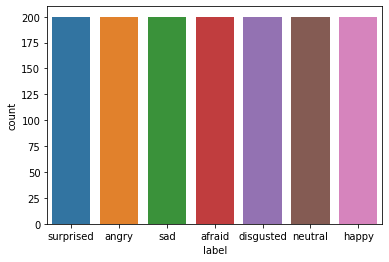

In [11]:
sns.countplot(train['label'])

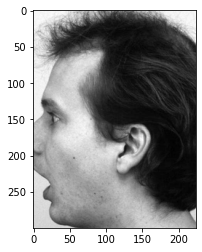

In [12]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

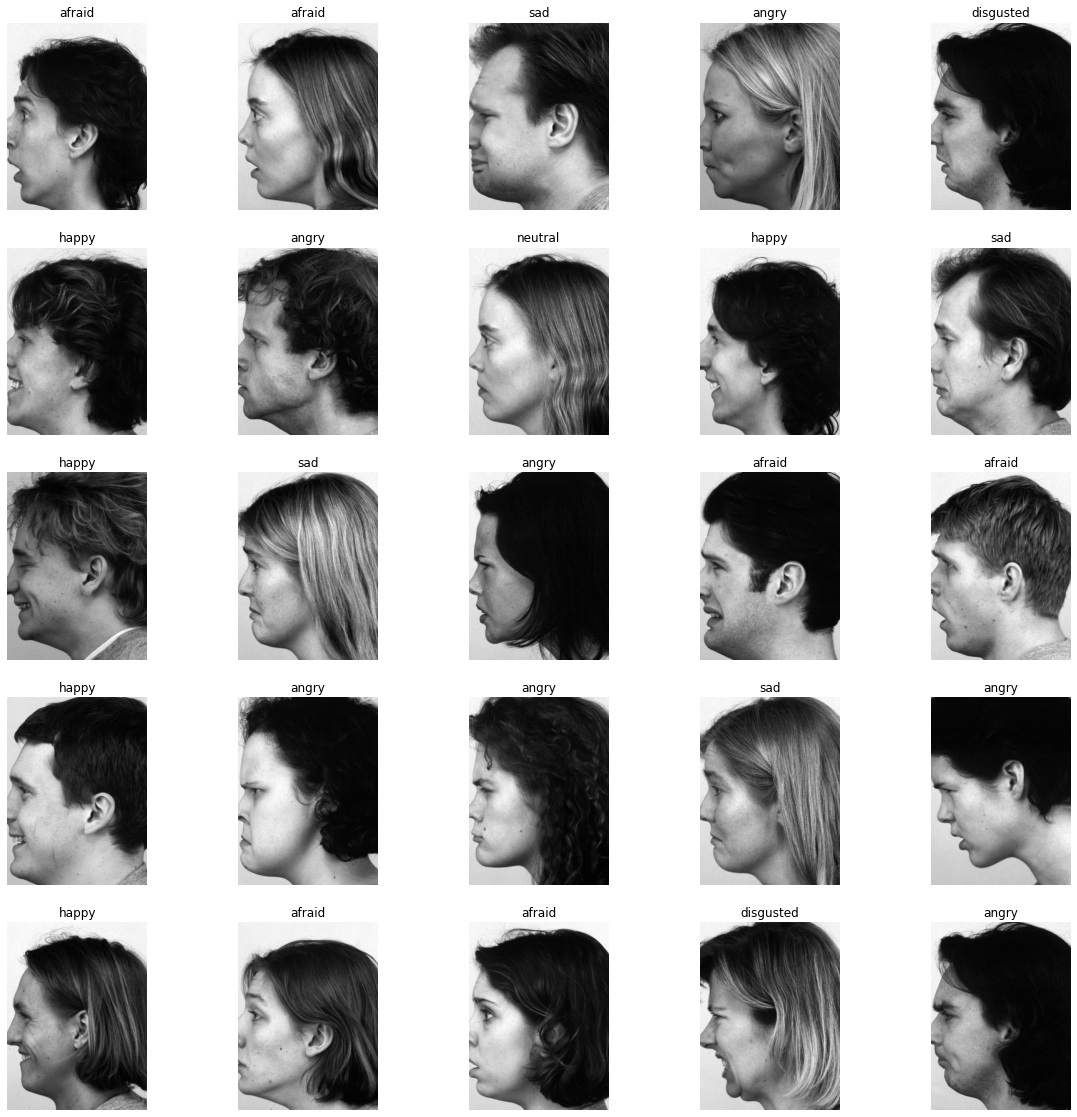

In [15]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [16]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [17]:
train_features = extract_features(train['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [18]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [19]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [20]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [21]:
print(y_train[0])
print(y_test[0])

[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [22]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [23]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 111, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 111, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 73, 54, 256)       0

In [24]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 19s 358ms/step - loss: 1.9580 - accuracy: 0.1314 - val_loss: 1.9456 - val_accuracy: 0.1607
Epoch 2/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9426 - accuracy: 0.1700 - val_loss: 1.9453 - val_accuracy: 0.1761
Epoch 3/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9406 - accuracy: 0.1629 - val_loss: 1.9450 - val_accuracy: 0.1679
Epoch 4/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9337 - accuracy: 0.1671 - val_loss: 1.9447 - val_accuracy: 0.1725
Epoch 5/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9260 - accuracy: 0.1886 - val_loss: 1.9442 - val_accuracy: 0.1693
Epoch 6/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9188 - accuracy: 0.2107 - val_loss: 1.9437 - val_accuracy: 0.1764
Epoch 7/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9192 - accuracy: 0.1886 - val_loss: 1.9430 - val_accuracy: 0.185

## Plot the Results

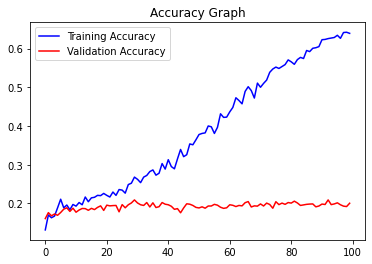

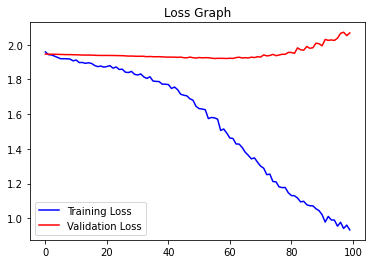

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [26]:
model.save('fer_fullLeft_v2.h5')

In [27]:
!cp fer_fullLeft_v2.h5 /content/drive/MyDrive

# 👈 Half Left Model 


> Half Left 사진만 학습할 모델

---





In [29]:
TRAIN_DIR = '/content/KDEF_Angle_V2/Train/halfLeft/'

In [30]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_Angle_V2/Train/halfLeft/happy/AF...      happy
1  /content/KDEF_Angle_V2/Train/halfLeft/surprise...  surprised
2  /content/KDEF_Angle_V2/Train/halfLeft/angry/BM...      angry
3  /content/KDEF_Angle_V2/Train/halfLeft/happy/AM...      happy
4  /content/KDEF_Angle_V2/Train/halfLeft/angry/BM...      angry

## Exploratory Data Analysis

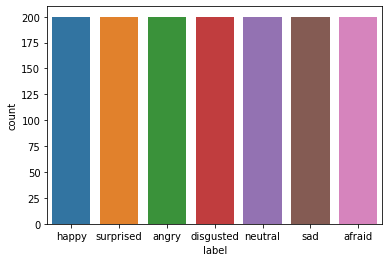

In [31]:
sns.countplot(train['label'])

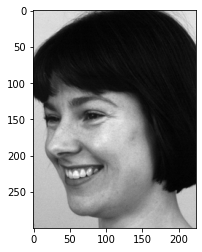

In [32]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

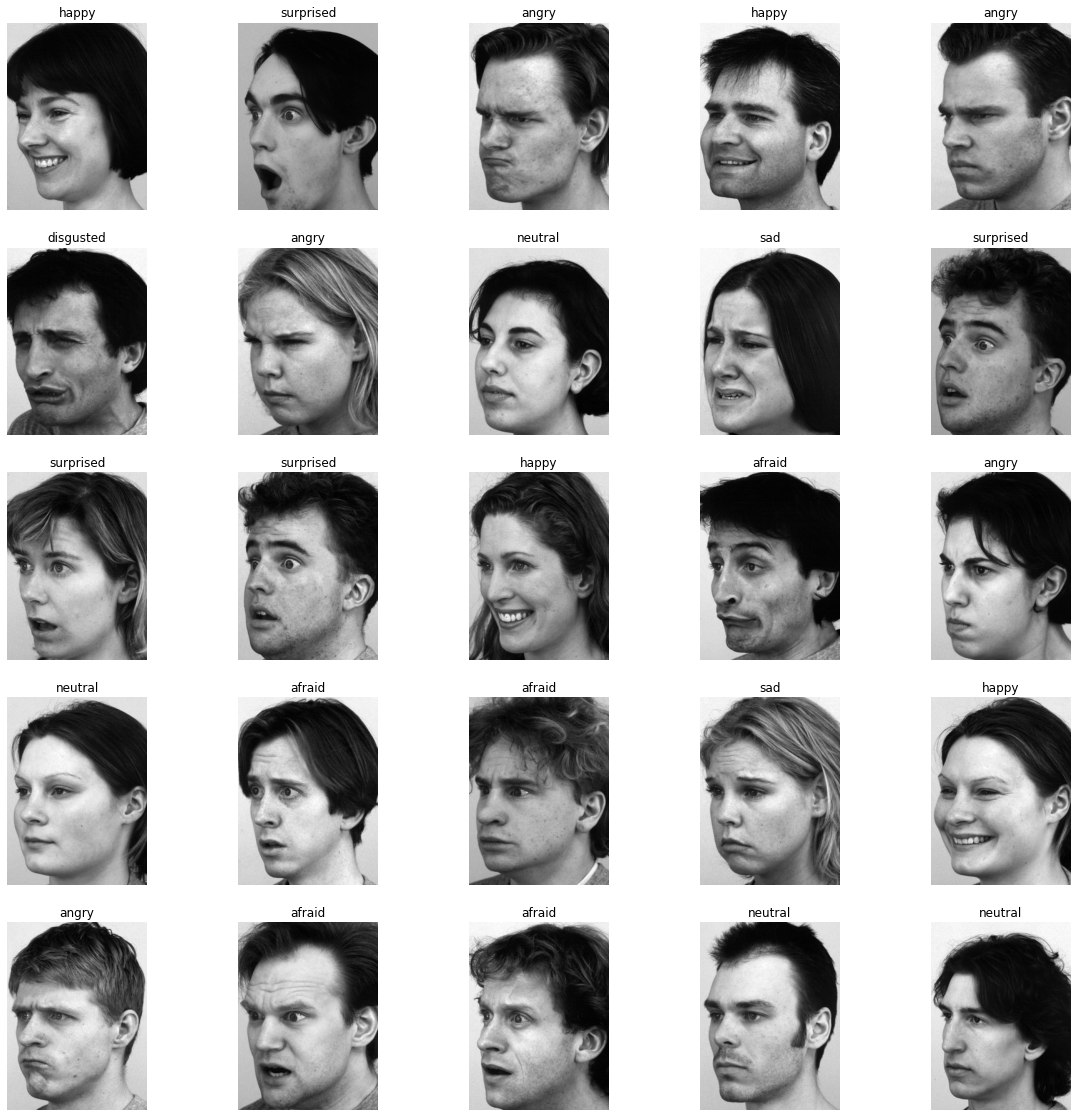

In [33]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [34]:
train_features = extract_features(train['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [35]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [36]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [37]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [38]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [39]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [40]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [41]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 149, 111, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 73, 54, 256)      

In [42]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 6s 248ms/step - loss: 1.9512 - accuracy: 0.1521 - val_loss: 1.9455 - val_accuracy: 0.1432
Epoch 2/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9447 - accuracy: 0.1500 - val_loss: 1.9452 - val_accuracy: 0.1564
Epoch 3/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9446 - accuracy: 0.1643 - val_loss: 1.9449 - val_accuracy: 0.1786
Epoch 4/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9376 - accuracy: 0.1721 - val_loss: 1.9447 - val_accuracy: 0.1864
Epoch 5/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9306 - accuracy: 0.1821 - val_loss: 1.9442 - val_accuracy: 0.1811
Epoch 6/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9346 - accuracy: 0.1986 - val_loss: 1.9440 - val_accuracy: 0.1996
Epoch 7/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9163 - accuracy: 0.1893 - val_loss: 1.9431 - val_accuracy: 0.2011

## Plot the Results

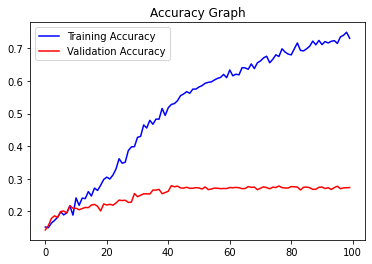

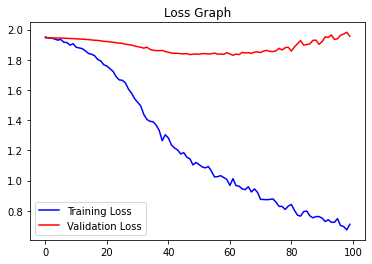

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [44]:
model.save('fer_halfLeft_v2.h5')

In [45]:
!cp fer_halfLeft_v2.h5 /content/drive/MyDrive

# 🧑 Straight Model 


> Straight 사진만 학습할 모델

---





In [46]:
TRAIN_DIR = '/content/KDEF_Angle_V2/Train/straight/'

In [47]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_Angle_V2/Train/straight/angry/AF...      angry
1  /content/KDEF_Angle_V2/Train/straight/sad/AM15...        sad
2  /content/KDEF_Angle_V2/Train/straight/surprise...  surprised
3  /content/KDEF_Angle_V2/Train/straight/neutral/...    neutral
4  /content/KDEF_Angle_V2/Train/straight/happy/BM...      happy

## Exploratory Data Analysis

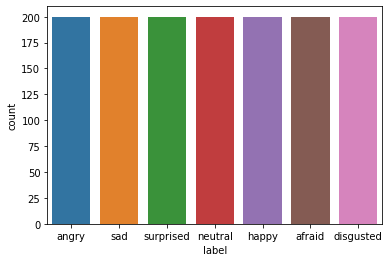

In [48]:
sns.countplot(train['label'])

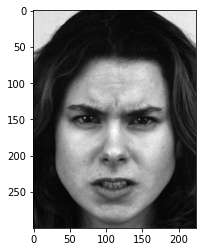

In [49]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

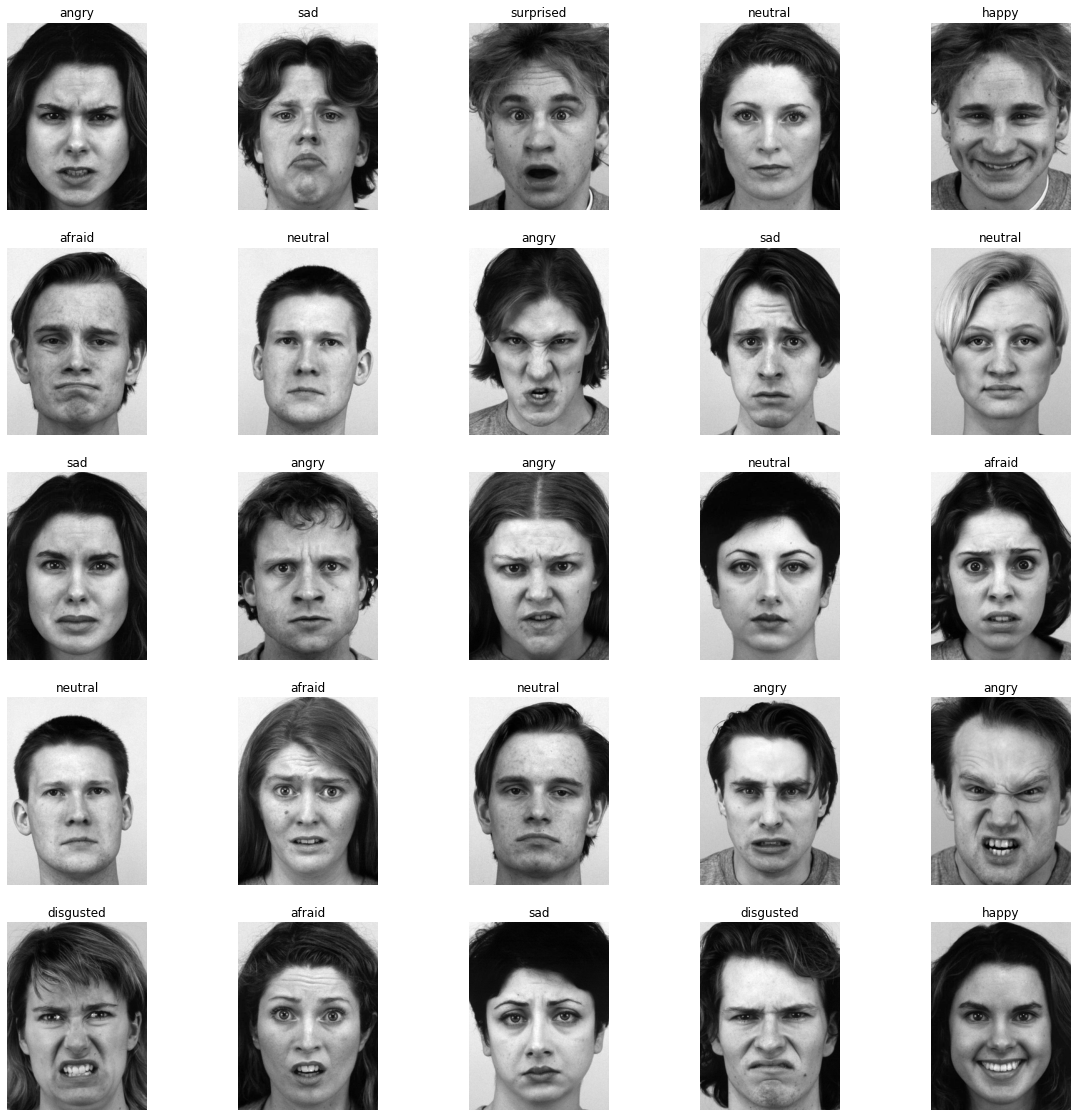

In [50]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [51]:
train_features = extract_features(train['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [52]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [53]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [54]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [55]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [56]:
print(y_train[0])
print(y_test[0])

[0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [57]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [58]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 149, 111, 128)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 73, 54, 256)      

In [59]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 6s 237ms/step - loss: 1.9585 - accuracy: 0.1450 - val_loss: 1.9455 - val_accuracy: 0.1489
Epoch 2/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9468 - accuracy: 0.1564 - val_loss: 1.9452 - val_accuracy: 0.1496
Epoch 3/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9375 - accuracy: 0.1600 - val_loss: 1.9448 - val_accuracy: 0.1457
Epoch 4/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9309 - accuracy: 0.1736 - val_loss: 1.9445 - val_accuracy: 0.1518
Epoch 5/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9276 - accuracy: 0.1829 - val_loss: 1.9441 - val_accuracy: 0.1636
Epoch 6/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9277 - accuracy: 0.1786 - val_loss: 1.9435 - val_accuracy: 0.1682
Epoch 7/100
22/22 [==============================] - 4s 199ms/step - loss: 1.9136 - accuracy: 0.2014 - val_loss: 1.9427 - val_accuracy: 0.1861

## Plot the Results

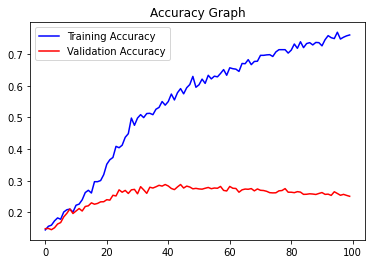

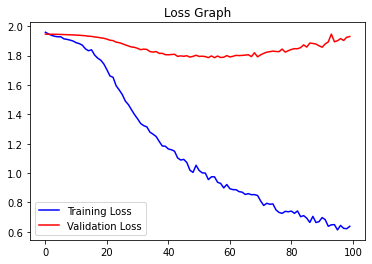

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [61]:
model.save('fer_straight_v2.h5')

In [62]:
!cp fer_straight_v2.h5 /content/drive/MyDrive

# 👉 Half Right Model 


> Half Right 사진만 학습할 모델

---





In [63]:
TRAIN_DIR = '/content/KDEF_Angle_V2/Train/halfRight/'

In [64]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_Angle_V2/Train/halfRight/neutral...    neutral
1  /content/KDEF_Angle_V2/Train/halfRight/happy/B...      happy
2  /content/KDEF_Angle_V2/Train/halfRight/afraid/...     afraid
3  /content/KDEF_Angle_V2/Train/halfRight/disgust...  disgusted
4  /content/KDEF_Angle_V2/Train/halfRight/afraid/...     afraid

## Exploratory Data Analysis

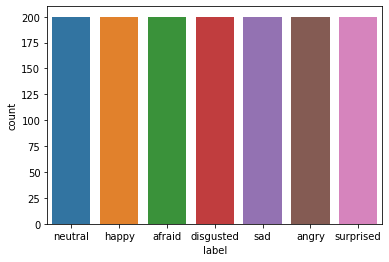

In [65]:
sns.countplot(train['label'])

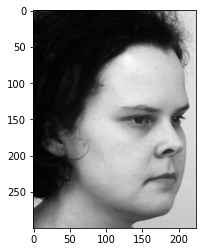

In [66]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

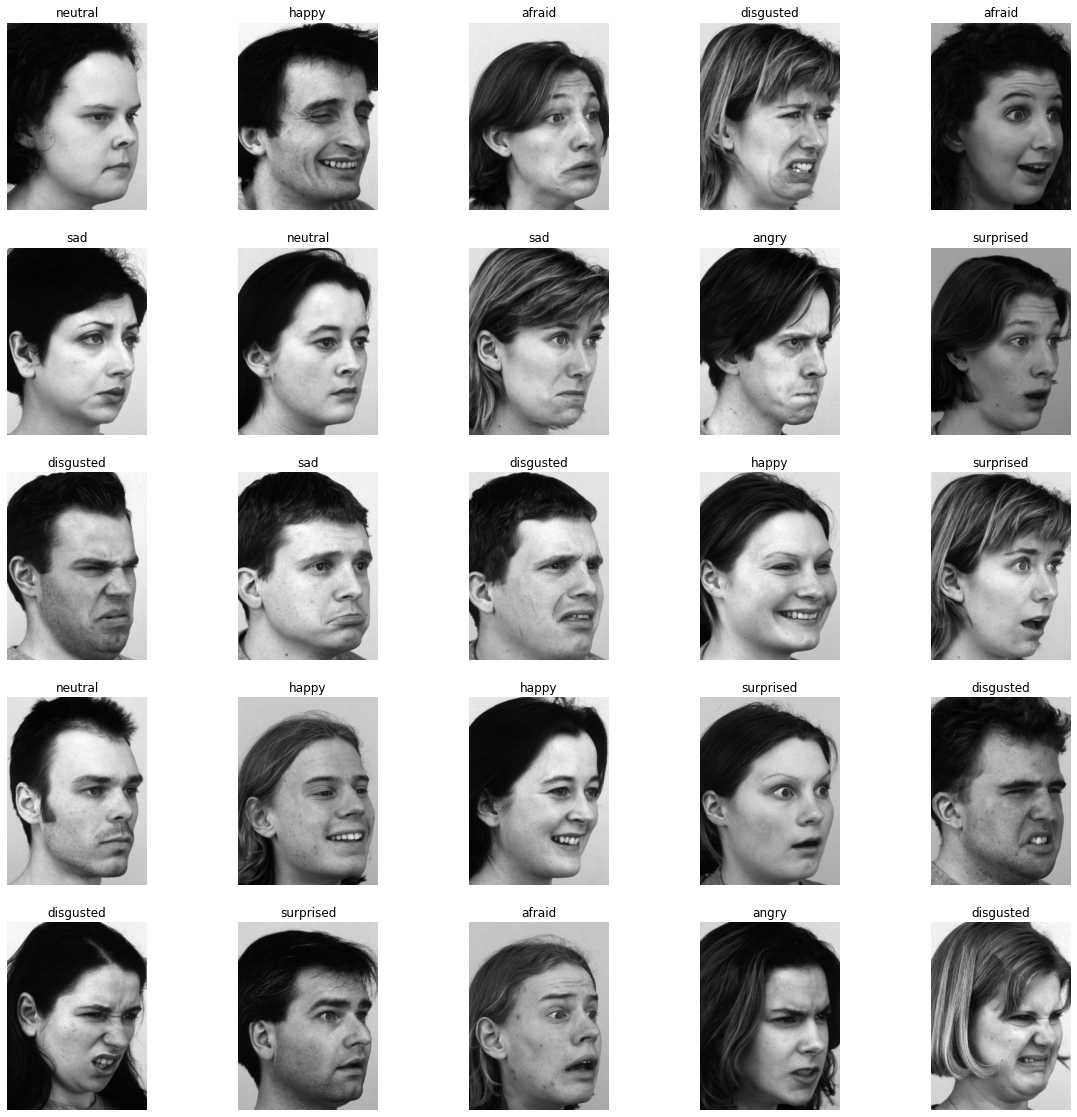

In [67]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [68]:
train_features = extract_features(train['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [69]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [70]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [71]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [72]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [73]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [74]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [75]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 149, 111, 128)    0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 149, 111, 128)     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 73, 54, 256)      0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 73, 54, 256)      

In [76]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 6s 236ms/step - loss: 1.9515 - accuracy: 0.1500 - val_loss: 1.9455 - val_accuracy: 0.1711
Epoch 2/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9439 - accuracy: 0.1507 - val_loss: 1.9451 - val_accuracy: 0.1668
Epoch 3/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9409 - accuracy: 0.1736 - val_loss: 1.9446 - val_accuracy: 0.1921
Epoch 4/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9307 - accuracy: 0.1893 - val_loss: 1.9440 - val_accuracy: 0.1943
Epoch 5/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9237 - accuracy: 0.1950 - val_loss: 1.9436 - val_accuracy: 0.2043
Epoch 6/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9208 - accuracy: 0.1914 - val_loss: 1.9430 - val_accuracy: 0.1918
Epoch 7/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9198 - accuracy: 0.1786 - val_loss: 1.9420 - val_accuracy: 0.2189

## Plot the Results

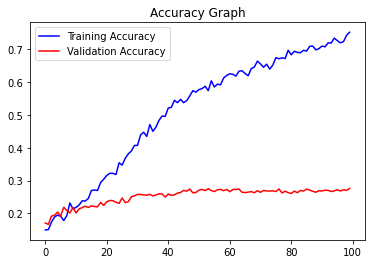

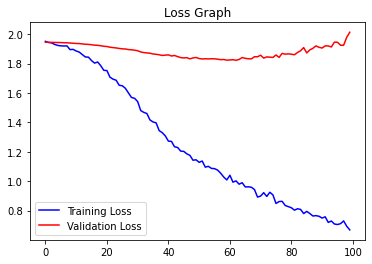

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [78]:
model.save('fer_halfRight_v2.h5')

In [79]:
!cp fer_halfRight_v2.h5 /content/drive/MyDrive

# 👉👉 Full Right Model 


> Full Right 사진만 학습할 모델

---





In [28]:
TRAIN_DIR = '/content/KDEF_Angle_V2/Train/fullRight/'

In [29]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_Angle_V2/Train/fullRight/neutral...    neutral
1  /content/KDEF_Angle_V2/Train/fullRight/afraid/...     afraid
2  /content/KDEF_Angle_V2/Train/fullRight/disgust...  disgusted
3  /content/KDEF_Angle_V2/Train/fullRight/sad/AF3...        sad
4  /content/KDEF_Angle_V2/Train/fullRight/neutral...    neutral

## Exploratory Data Analysis

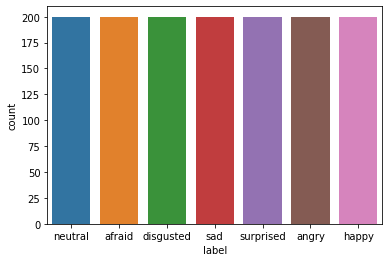

In [30]:
sns.countplot(train['label'])

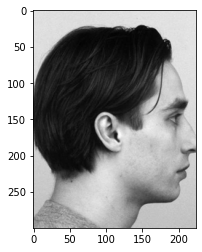

In [31]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

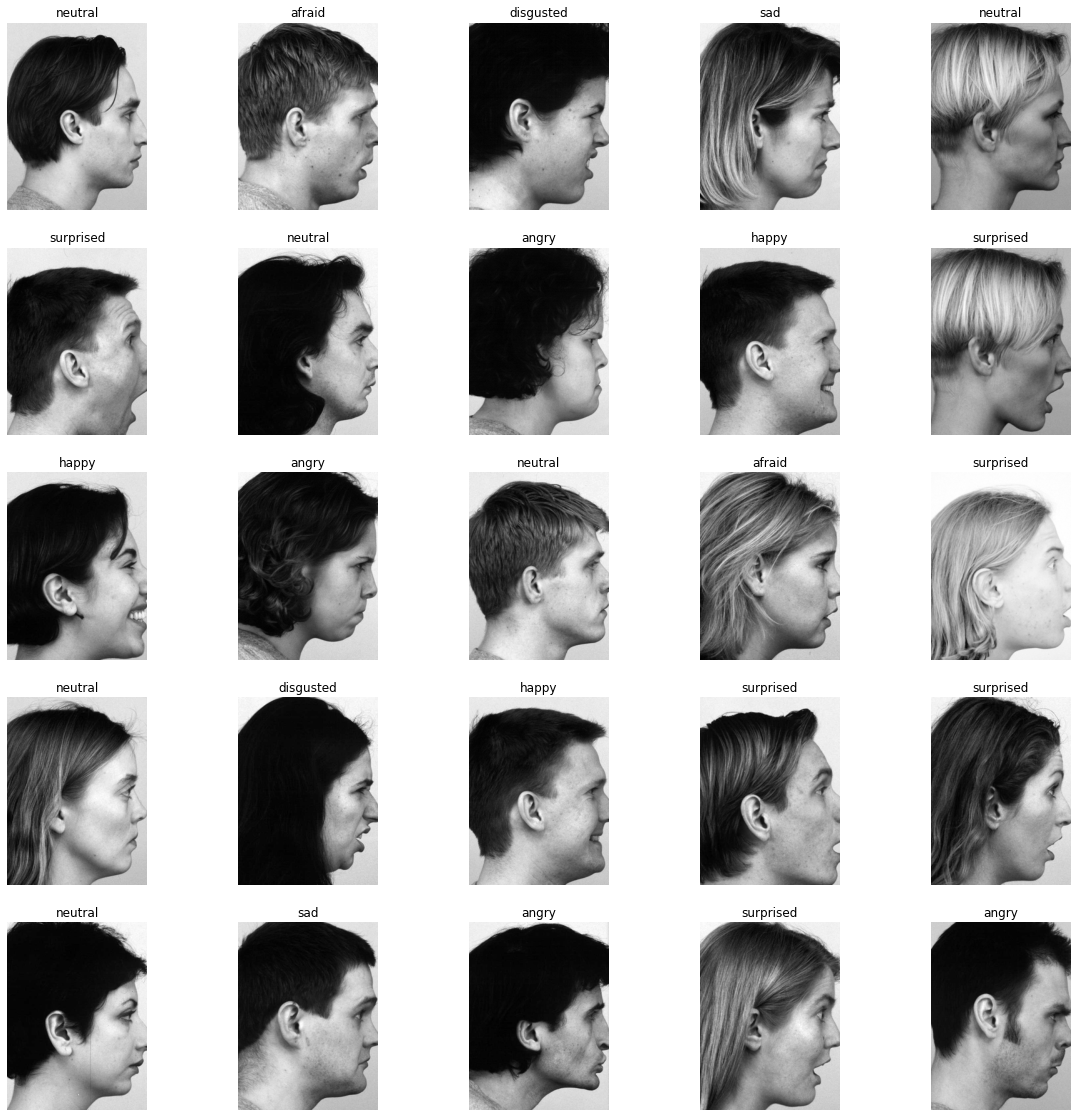

In [32]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [33]:
train_features = extract_features(train['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [34]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [35]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [36]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [37]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [38]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [39]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [40]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 149, 111, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 73, 54, 256)      

In [41]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 6s 247ms/step - loss: 1.9509 - accuracy: 0.1536 - val_loss: 1.9458 - val_accuracy: 0.1529
Epoch 2/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9407 - accuracy: 0.1529 - val_loss: 1.9452 - val_accuracy: 0.1711
Epoch 3/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9337 - accuracy: 0.1721 - val_loss: 1.9449 - val_accuracy: 0.1650
Epoch 4/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9337 - accuracy: 0.1800 - val_loss: 1.9445 - val_accuracy: 0.1689
Epoch 5/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9309 - accuracy: 0.1771 - val_loss: 1.9441 - val_accuracy: 0.1711
Epoch 6/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9279 - accuracy: 0.1793 - val_loss: 1.9439 - val_accuracy: 0.1600
Epoch 7/100
22/22 [==============================] - 4s 198ms/step - loss: 1.9212 - accuracy: 0.1793 - val_loss: 1.9433 - val_accuracy: 0.1696

## Plot the Results

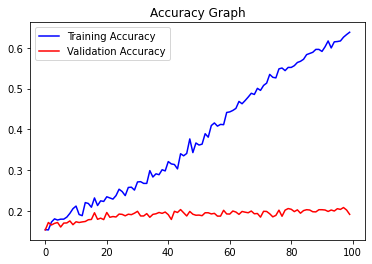

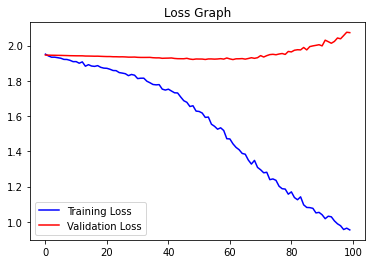

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [43]:
model.save('fer_fullRight_v2.h5')

In [44]:
!cp fer_fullRight_v2.h5 /content/drive/MyDrive

# 🏭 Ensemble Model


> 5개의 모델을 앙상블



## Feature Extraction

In [45]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [46]:
## normalize the image
x_test = test_features/255.0

In [47]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [48]:
print(y_test)

[6 6 6 ... 0 0 0]


## Evaluate Ensemble

In [13]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [14]:
model_fullLeft = tf.keras.models.load_model('/content/drive/MyDrive/fer_fullLeft_v2.h5')
model_halfLeft = tf.keras.models.load_model('/content/drive/MyDrive/fer_halfLeft_v2.h5')
model_straight = tf.keras.models.load_model('/content/drive/MyDrive/fer_straight_v2.h5')
model_halfRight = tf.keras.models.load_model('/content/drive/MyDrive/fer_halfRight_v2.h5')
model_fullRight = tf.keras.models.load_model('/content/drive/MyDrive/fer_fullRight_v2.h5')

In [15]:
models = [model_fullLeft, model_halfLeft, model_straight, model_halfRight, model_fullRight]

In [16]:
def ensemble_predictions(models, test_x):
    # make predictions
    yhats = [model.predict(test_x, verbose = 0) for model in models]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

In [17]:
def evaluate_ensemble_model(models, test_x, test_y):
    # make prediction
    yhat = [ensemble_predictions(models, testData.reshape(1, 300, 224, 1)) for testData in tqdm(test_x)]
    # calculate accuracy
    return accuracy_score(test_y, yhat)

In [54]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 2800/2800 [09:50<00:00,  4.74it/s]


In [55]:
print(f'Accuracy : {score}')

Accuracy : 0.37142857142857144


# Evaluate Model Only with Angle

In [18]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_TEST_FullLeft_V2.zip"

/content


In [19]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_HalfLeft_V2.zip"

In [20]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Straight_V2.zip"

In [21]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_HalfRight_V2.zip"

In [22]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_FullRight_V2.zip"

## Full Left

In [24]:
TEST_DIR_FullLeft = '/content/KDEF_TEST_FullLeft_V2/'

In [25]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_FullLeft)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_FullLeft_V2/surprised/BF08S...  surprised
1  /content/KDEF_TEST_FullLeft_V2/surprised/BM07S...  surprised
2  /content/KDEF_TEST_FullLeft_V2/surprised/AM06S...  surprised
3  /content/KDEF_TEST_FullLeft_V2/surprised/BM08S...  surprised
4  /content/KDEF_TEST_FullLeft_V2/surprised/BF04S...  surprised

In [26]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:07<00:00, 73.71it/s]


(560, 300, 224, 1)


In [27]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [28]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [02:28<00:00,  3.78it/s]


In [29]:
print(f'Accuracy : {score}')

Accuracy : 0.2857142857142857


## Half Left

In [30]:
TEST_DIR_HalfLeft = '/content/KDEF_TEST_HalfLeft_V2/'

In [31]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_HalfLeft)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_HalfLeft_V2/surprised/BF05S...  surprised
1  /content/KDEF_TEST_HalfLeft_V2/surprised/BF03S...  surprised
2  /content/KDEF_TEST_HalfLeft_V2/surprised/AF03S...  surprised
3  /content/KDEF_TEST_HalfLeft_V2/surprised/AM02S...  surprised
4  /content/KDEF_TEST_HalfLeft_V2/surprised/BF08S...  surprised

In [32]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:05<00:00, 111.71it/s]


(560, 300, 224, 1)


In [33]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [34]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [02:22<00:00,  3.93it/s]


In [35]:
print(f'Accuracy : {score}')

Accuracy : 0.4660714285714286


## Straight

In [36]:
TEST_DIR_Straight = '/content/KDEF_TEST_Straight_V2/'

In [37]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Straight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_Straight_V2/surprised/AM04S...  surprised
1  /content/KDEF_TEST_Straight_V2/surprised/BM08S...  surprised
2  /content/KDEF_TEST_Straight_V2/surprised/AM02S...  surprised
3  /content/KDEF_TEST_Straight_V2/surprised/BM07S...  surprised
4  /content/KDEF_TEST_Straight_V2/surprised/AF08S...  surprised

In [38]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:04<00:00, 112.71it/s]


(560, 300, 224, 1)


In [39]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [40]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [02:20<00:00,  3.99it/s]


In [41]:
print(f'Accuracy : {score}')

Accuracy : 0.3535714285714286


## Half Right

In [42]:
TEST_DIR_HalfRight = '/content/KDEF_TEST_HalfRight_V2/'

In [43]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_HalfRight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_HalfRight_V2/surprised/BM05...  surprised
1  /content/KDEF_TEST_HalfRight_V2/surprised/BF05...  surprised
2  /content/KDEF_TEST_HalfRight_V2/surprised/BM09...  surprised
3  /content/KDEF_TEST_HalfRight_V2/surprised/BF03...  surprised
4  /content/KDEF_TEST_HalfRight_V2/surprised/BM06...  surprised

In [44]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:05<00:00, 111.59it/s]


(560, 300, 224, 1)


In [45]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [46]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [02:21<00:00,  3.96it/s]


In [47]:
print(f'Accuracy : {score}')

Accuracy : 0.46964285714285714


## Full Right

In [48]:
TEST_DIR_FullRight = '/content/KDEF_TEST_FullRight_V2/'

In [49]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_FullRight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_FullRight_V2/surprised/BF03...  surprised
1  /content/KDEF_TEST_FullRight_V2/surprised/AF01...  surprised
2  /content/KDEF_TEST_FullRight_V2/surprised/AM05...  surprised
3  /content/KDEF_TEST_FullRight_V2/surprised/AM02...  surprised
4  /content/KDEF_TEST_FullRight_V2/surprised/AM10...  surprised

In [50]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:05<00:00, 100.27it/s]


(560, 300, 224, 1)


In [51]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [52]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [02:21<00:00,  3.96it/s]


In [53]:
print(f'Accuracy : {score}')

Accuracy : 0.28214285714285714


# Evaluate Model Only with Emotion

In [18]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Afraid_V2.zip"

/content


In [19]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Angry_V2.zip"

In [20]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Disgusted_V2.zip"

In [21]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Happy_V2.zip"

In [22]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Neutral_V2.zip"

In [23]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Sad_V2.zip"

In [24]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Surprised_V2.zip"

## Afraid

In [29]:
TEST_DIR_Afraid = '/content/KDEF_TEST_Afraid_V2/'

In [30]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Afraid)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image   label
0  /content/KDEF_TEST_Afraid_V2/afraid/BF06AFS_AU...  afraid
1   /content/KDEF_TEST_Afraid_V2/afraid/AM07AFHR.JPG  afraid
2  /content/KDEF_TEST_Afraid_V2/afraid/BF08AFHR_A...  afraid
3   /content/KDEF_TEST_Afraid_V2/afraid/AM07AFHL.JPG  afraid
4  /content/KDEF_TEST_Afraid_V2/afraid/AM04AFHL_A...  afraid

In [31]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:08<00:00, 49.04it/s]


(400, 300, 224, 1)


In [32]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [33]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


In [34]:
print(f'Accuracy : {score}')

Accuracy : 0.295


## Angry

In [35]:
TEST_DIR_Angry = '/content/KDEF_TEST_Angry_V2/'

In [36]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Angry)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image  label
0     /content/KDEF_TEST_Angry_V2/angry/BF08ANHL.JPG  angry
1  /content/KDEF_TEST_Angry_V2/angry/BF06ANFL_AUG...  angry
2     /content/KDEF_TEST_Angry_V2/angry/AF02ANFR.JPG  angry
3     /content/KDEF_TEST_Angry_V2/angry/AM04ANFL.JPG  angry
4  /content/KDEF_TEST_Angry_V2/angry/AF10ANFR_AUG...  angry

In [37]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 103.25it/s]


(400, 300, 224, 1)


In [38]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [39]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:44<00:00,  3.81it/s]


In [40]:
print(f'Accuracy : {score}')

Accuracy : 0.465


## Disgusted

In [41]:
TEST_DIR_Disgusted = '/content/KDEF_TEST_Disgusted_V2/'

In [42]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Disgusted)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_Disgusted_V2/disgusted/AF07...  disgusted
1  /content/KDEF_TEST_Disgusted_V2/disgusted/BF08...  disgusted
2  /content/KDEF_TEST_Disgusted_V2/disgusted/AF09...  disgusted
3  /content/KDEF_TEST_Disgusted_V2/disgusted/BM08...  disgusted
4  /content/KDEF_TEST_Disgusted_V2/disgusted/BF04...  disgusted

In [43]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 104.73it/s]


(400, 300, 224, 1)


In [44]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [45]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:45<00:00,  3.80it/s]


In [46]:
print(f'Accuracy : {score}')

Accuracy : 0.7075


## Happy

In [47]:
TEST_DIR_Happy= '/content/KDEF_TEST_Happy_V2/'

In [48]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Happy)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image  label
0      /content/KDEF_TEST_Happy_V2/happy/AM07HAS.JPG  happy
1  /content/KDEF_TEST_Happy_V2/happy/BM03HAFL_AUG...  happy
2     /content/KDEF_TEST_Happy_V2/happy/BM06HAHR.JPG  happy
3     /content/KDEF_TEST_Happy_V2/happy/AM10HAHR.JPG  happy
4  /content/KDEF_TEST_Happy_V2/happy/AM01HAS_AUG.jpg  happy

In [49]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 105.99it/s]


(400, 300, 224, 1)


In [50]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [51]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:47<00:00,  3.72it/s]


In [52]:
print(f'Accuracy : {score}')

Accuracy : 0.48


## Neutral

In [53]:
TEST_DIR_Neutral = '/content/KDEF_TEST_Neutral_V2/'

In [54]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Neutral)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image    label
0  /content/KDEF_TEST_Neutral_V2/neutral/AM07NEHL...  neutral
1  /content/KDEF_TEST_Neutral_V2/neutral/BM04NEFR...  neutral
2  /content/KDEF_TEST_Neutral_V2/neutral/BF10NES.JPG  neutral
3  /content/KDEF_TEST_Neutral_V2/neutral/BM01NEHR...  neutral
4  /content/KDEF_TEST_Neutral_V2/neutral/BF07NEHR...  neutral

In [55]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 100.77it/s]


(400, 300, 224, 1)


In [56]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [57]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:43<00:00,  3.85it/s]


In [58]:
print(f'Accuracy : {score}')

Accuracy : 0.1625


## Sad

In [59]:
TEST_DIR_Sad = '/content/KDEF_TEST_Sad_V2/'

In [60]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Sad)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image label
0  /content/KDEF_TEST_Sad_V2/sad/BF06SAHR_AUG.jpg   sad
1  /content/KDEF_TEST_Sad_V2/sad/AF01SAHL_AUG.jpg   sad
2      /content/KDEF_TEST_Sad_V2/sad/BF05SAHR.JPG   sad
3   /content/KDEF_TEST_Sad_V2/sad/BF01SAS_AUG.jpg   sad
4  /content/KDEF_TEST_Sad_V2/sad/BM09SAFL_AUG.jpg   sad

In [61]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 107.23it/s]


(400, 300, 224, 1)


In [62]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [63]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:47<00:00,  3.71it/s]


In [64]:
print(f'Accuracy : {score}')

Accuracy : 0.125


## Surprised

In [65]:
TEST_DIR_Surprised = '/content/KDEF_TEST_Surprised_V2/'

In [66]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Surprised)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_Surprised_V2/surprised/BF03...  surprised
1  /content/KDEF_TEST_Surprised_V2/surprised/AM04...  surprised
2  /content/KDEF_TEST_Surprised_V2/surprised/BM05...  surprised
3  /content/KDEF_TEST_Surprised_V2/surprised/AF01...  surprised
4  /content/KDEF_TEST_Surprised_V2/surprised/BF08...  surprised

In [67]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 106.10it/s]

(400, 300, 224, 1)


In [68]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [69]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:47<00:00,  3.72it/s]


In [70]:
print(f'Accuracy : {score}')

Accuracy : 0.365
